In [2]:
from __future__ import annotations

import random
from typing import Any

import numpy as np
from gym import Env
from gym.spaces import Box
from gym.spaces import Discrete
from numpy.typing import NDArray

import numpy as np
import matplotlib.pyplot as plt

# Planning

## Task List
- ~~Drill multiple wells, one after the other and not to update the environment after every simulation.~~
- ~~Make sure well/wells dont crash into each other/itself or any faults/artifacts~~
- ~~Avoid 180 degree turns~~
- Have a target zone where the well eventually want to make it to and get higher reward
- Use a metric like MSE/UCS to get an estimate on the amount of energy required to drill and optimizing it to have lowest energy usage (also tie in the economic constraints)

## Action Space
- Surface Location ?? Pick it randomly or intentionally?
- Number of wells to drill
- Bit Movement
    -  Up
    -  Down
    -  Left
    -  Right
    -  Angle ?? If the grid size is as much as a stand then the max angle should be around 3 degrees 

## Observation Space

Same shape [matrix] as the input. Ideally 30 ft by 30 ft to match with the drilling pipe (90 ft by 90 ft for stand). Bool with true for wherever well is located.

## Possible Rewards
- While Drilling
    -  Proximity to Reservoir (based on the percentage of Normalized TOC?) - *Positive Reward*
    -  Proximity to Fault - *VERY HIGH Negative Reward*
    -  Proximity to itself or other wells - *VERY HIGH Negative Reward*
    -  Proximity to the possible depletion zone of an existing well - *VERY HIGH Negative Reward*
    -  Remaining oil in the zone of the well - *High Positive Reward*

- After Drilling
    -  Total UCS/MSE it was drilled through - *Negative Reward based on the UCS total, can also relate it to a USD amount*    
    -  Total Well Length - *Negative Reward based on the pipe count, can also relate it to a USD amount* 

# Simple Environment

In [3]:
class SimpleDriller(Env):  # type: ignore
    """Simple driller environment."""

    def __init__(self, env_config: dict[str, Any]) -> None:
        """Initialize environment with config dictionary."""
        self.model = np.loadtxt(
            env_config["model_path"],
            delimiter=env_config["delim"],
        )

        self.nrow, self.ncol = self.model.shape
        self.available_pipe = env_config["available_pipe"]

        self.production = 0
        self.pipe_used = 0
        self.trajectory: list[list[int]] = []
        self.bit_location: list[int] = []

        self.action_space = Discrete(4)

        self.observation_space = Box(
            low=0, high=1, shape=(self.nrow, self.ncol), dtype="bool"
        )
        self.reset()

    def step(  # noqa: C901
        self, action: int
    ) -> tuple[NDArray[np.bool_], int, bool, dict[str, Any]]:
        """Take step based on action."""
        done = False
        actions = {
            0: [1, 0],  # down
            1: [0, -1],  # left
            2: [0, 1],  # right
            3: [-1, 0],  # up
        }

        dz_dx = actions[action]
        new_location = [prev + now for prev, now in zip(self.bit_location, dz_dx)]

        self.bit_location = new_location

        self.trajectory.append(new_location)
        newrow, newcol = new_location

        self.pipe_used += 1

        if newrow < 1 or newrow >= self.nrow:
            done = True
            reward = -100

        elif newcol < 0 or newcol >= self.ncol:
            done = True
            reward = -100

        else:
            reward = self.model[newrow, newcol] + self.pipe_used / 2
            self.update_state()

        if self.pipe_used == self.available_pipe:
            done = True
            reward = 0

        if self.bit_location in self.trajectory[:-1]:
            done = True
            reward = -100

        info: dict[str, Any] = {}

        return self.state, reward, done, info

    def update_state(self) -> None:
        """Update state method."""
        traj_i, traj_j = np.asarray(self.trajectory).T
        self.state[traj_i, traj_j] = 1

    def render(self) -> None:
        """Gym environment rendering."""
        raise NotImplementedError("No renderer implemented yet.")

    def reset(self) -> NDArray[np.bool_]:
        """Reset the status of the environment."""
        self.surface_hole_location = [1, random.randint(0, self.ncol - 1)]  # noqa: S311
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        self.bit_location = self.surface_hole_location
        self.trajectory = [self.surface_hole_location]
        self.pipe_used = 0
        return self.state


# Multidriller Environment

In [4]:
class MultiDriller(Env):  # type: ignore
    """Simple driller environment for multiple wells"""

    def __init__(self, env_config: dict[str, Any]) -> None:
        """Initialize environment with config dictionary."""
        
        self.model = np.loadtxt(env_config["model_path"],
                                delimiter=env_config["delim"])
        
        self.nrow, self.ncol = self.model.shape
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        
        self.available_pipe = env_config["available_pipe"]
            
        self.num_wells = env_config["num_wells"]
                
        
        self.wells_drilled = 0 
        self.reward = 0
        self.multi_reward = 0

        self.production = 0
        self.pipe_used = 0
        self.trajectory: list[list[int]] = []
        self.bit_location: list[int] = []
        self.surface_location = []
        self.last_action = None
            
            
        self.multi_trajectory: list[list[list[int]]] = []
        self.action_space = Discrete(4)        

        self.observation_space = Box(low=0, high=1, 
                                     shape=(self.nrow, self.ncol), 
                                     dtype="bool")
        self.reset_well()
        self.reset()
    
# ----------------------------------------------------------------------------------------------------------------      

    def step(self, action: int) -> tuple[NDArray[np.bool_], int, bool, dict[str, Any]]:
        """Take step based on action."""
        
        done = False
#         reward = 0
#         self.reset_well()
        
        actions = {
                   0: [1, 0],  # down
                   1: [0, -1],  # left
                   2: [0, 1],  # right
                   3: [-1, 0],  # up
                  }

        dz_dx = actions[action]
        new_location = [prev + now for prev, now in zip(self.bit_location, dz_dx)]

        self.bit_location = new_location

        self.trajectory.append(new_location)
        newrow, newcol = new_location

        self.pipe_used += 1

        if newrow < 1 or newrow >= self.nrow:
            done = True
            self.reward = -100
#             print('    Number of Rows exceeded')
#             reward = 0

        elif newcol < 0 or newcol >= self.ncol:
            done = True
            self.reward = -100
#             print('    Number of Cols exceeded')
#             reward = 0

        else:
            reward = self.model[newrow, newcol] + self.pipe_used / 2
            if len(self.trajectory)>0:
                self.update_state()

        if self.pipe_used == self.available_pipe:
            done = True
            self.reward = 0
#             print('    Done with total pipes')

        if self.bit_location in self.trajectory[:-1]:
            done = True
            self.reward = -100
#             print('    Crashed onto itself')
#             reward = 0
            
        if self.bit_location in [item for sublist in self.multi_trajectory for item in sublist]:
            done = True
            self.reward = -100
#             print('    Crashed into a different well')
        
        # Avoid immediate 180 degree turns
        if (self.last_action != None):
            if (np.add(actions[action], actions[self.last_action]).tolist() == [0,0]):
#                 done = True
                self.reward = -1000    
#                 print('    Immediate 180 degree turn')
    
        info: dict[str, Any] = {}
        
        if done:
            self.wells_drilled += 1            
            self.multi_reward += self.reward 
            
            if len(self.trajectory)>0:
                self.multi_trajectory.append(self.trajectory)
                
            self.reset_well()
            
            if self.wells_drilled < self.num_wells:
                    done = False            
                    
            return self.state, self.multi_reward, done, info
        else:
            self.last_action = action
#             print(f'Last action: {actions[self.last_action]}')
            return self.state, self.reward, done, info

# ----------------------------------------------------------------------------------------------------------------      

    def update_state(self) -> None:
        """Update state method."""        
        traj_i, traj_j = np.asarray(self.trajectory).T
        self.state[traj_i, traj_j] = 1
            
# ----------------------------------------------------------------------------------------------------------------      

    def render(self) -> None:
        """Gym environment rendering."""
        raise NotImplementedError("No renderer implemented yet.")
        
# ----------------------------------------------------------------------------------------------------------------      

    def reset_well(self) -> NDArray[np.bool_]:
        """Reset the status of the environment."""
        
        # random surface location  that was not used before
        self.surface_hole_location = [0, random.choice(list(set(range(0, self.ncol - 1))-set(self.surface_location)))] 

        # Log the surface locations already used
        self.surface_location.append(self.surface_hole_location[1])
        
        self.bit_location = self.surface_hole_location            
        self.trajectory = [self.surface_hole_location]
        self.pipe_used = 0
        self.reward = 0
        
        return self.state

# ----------------------------------------------------------------------------------------------------------------      
    
    def reset(self) -> NDArray[np.bool_]:
        
        """Reset the status of the environment."""
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        self.multi_trajectory = []
        self.surface_location = []
        self.multi_reward = 0 
        self.wells_drilled = 0 
        return self.state


# Reward based on Proximity Environment

In [580]:
class RewardDriller(Env):  # type: ignore
    """Driller environment for multiple wells with rewards based on proximity to reservoir"""

    def __init__(self, env_config: dict[str, Any]) -> None:
        """Initialize environment with config dictionary."""
        
        self.model = np.loadtxt(env_config["model_path"],
                                delimiter=env_config["delim"])
        
#         # Trial model inputs
#         self.model[0] = self.model[0]+989
        
        self.nrow, self.ncol = self.model.shape
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        
        self.available_pipe = env_config["available_pipe"]

        self.num_wells = env_config["num_wells"]
        
        
        self.wells_drilled = 0 
        self.reward = 1
        self.multi_reward = 0
        self.last_action = None

        self.production = 0
        self.pipe_used = 0
        self.trajectory: list[list[int]] = []
        self.bit_location: list[int] = []
            
        # Surface location cache
        self.surface_location = []
            
        # Cache previous trajectories after the well is done drilling    
        self.multi_trajectory: list[list[list[int]]] = []
        self.action_space = Discrete(4)        

        self.observation_space = Box(low=0, high=1, 
                                     shape=(self.nrow, self.ncol), 
                                     dtype="bool")
        self.reset_well()
        self.reset()
    
# ----------------------------------------------------------------------------------------------------------------      

    def step(self, action: int) -> tuple[NDArray[np.bool_], int, bool, dict[str, Any]]:
        """Take step based on action."""
        
        done = False
        
        actions = {
                   0: [1, 0],  # down
                   1: [0, -1],  # left
                   2: [0, 1],  # right
                   3: [-1, 0],  # up
                  }

        dz_dx = actions[action]
        new_location = [prev + now for prev, now in zip(self.bit_location, dz_dx)]

        self.bit_location = new_location

        self.trajectory.append(new_location)
        newrow, newcol = new_location

        self.pipe_used += 1

        if newrow < 1 or newrow >= self.nrow:
            self.multi_reward = -100
            done = True
#             print('    Number of Rows exceeded')

        elif newcol < 0 or newcol >= self.ncol:
            self.multi_reward = -100
            done = True
#             print('    Number of Cols exceeded')

        else:
            # +ve reward for using pipes and  going towards good target
            self.reward += (self.model[newrow, newcol]*50) + (self.pipe_used*10)
             
            if len(self.trajectory) > 0:
                self.update_state()
                
            # Stop the well if it goes through a fault or negative entity in the model     
            if self.reward < 0:
                self.multi_reward = -100
                done = True
            else:
                self.multi_reward += self.reward
        
        # Avoid going along the surface
        if ((self.bit_location != self.surface_hole_location) & 
            (self.bit_location[0] == 0)):
            self.multi_reward = -100
            done = True
#             print('    Going along the surface horizontally')
    
        if self.pipe_used == self.available_pipe:
            done = True
            self.multi_reward += self.reward
#             print('    Done with total pipes')

        if self.bit_location in self.trajectory[:-1]:
            self.multi_reward = -100
            done = True
#             print('    Crashed onto itself')
            
        if self.bit_location in [item for sublist in self.multi_trajectory for item in sublist]:
            self.multi_reward = -100
            done = True
#             print('    Crashed into a different well')
        
        # Avoid immediate 180 degree turns
        if (self.last_action != None):
            if (np.add(actions[action], actions[self.last_action]).tolist() == [0,0]):
                self.multi_reward = -100
#                 print('    Immediate 180 degree turn')

        info: dict[str, Any] = {}
            
        if done:
            self.wells_drilled += 1 
            
            if len(self.trajectory)> 0:
                self.multi_trajectory.append(self.trajectory)
                
            self.reset_well()
            
            if self.wells_drilled < self.num_wells:
                    done = False            
        
        else:
            self.last_action = action
        
#         print(self.multi_reward)         
        
        return self.state, self.multi_reward, done, info
                

# ----------------------------------------------------------------------------------------------------------------      

    def update_state(self) -> None:
        """Update state method."""        
        traj_i, traj_j = np.asarray(self.trajectory).T
        self.state[traj_i, traj_j] = 1
            
# ----------------------------------------------------------------------------------------------------------------      

    def render(self) -> None:
        """Gym environment rendering."""
        raise NotImplementedError("No renderer implemented yet.")
        
# ----------------------------------------------------------------------------------------------------------------      

    def reset_well(self) -> NDArray[np.bool_]:
        """Reset the status of the environment."""
        
        # random surface location  that was not used before
        self.surface_hole_location = [0, random.choice(list(set(range(0, self.ncol - 1))-set(self.surface_location)))] 

        # Log the surface locations already used
        self.surface_location.append(self.surface_hole_location[1])
        
        self.bit_location = self.surface_hole_location            
        self.trajectory = [self.surface_hole_location]
        self.pipe_used = 0
        self.reward = 0
        
        return self.state

# ----------------------------------------------------------------------------------------------------------------      
    
    def reset(self) -> NDArray[np.bool_]:
        
        """Reset the status of the environment."""
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        self.multi_trajectory = []
        self.surface_location = []
        self.multi_reward = 0 
        self.wells_drilled = 0 
        return self.state


# Test Environment

Beginning Drill Campaign: 1
    Total Reward: -100
    Total Reward: -100
    Total Reward: -90.0
    Total Reward: -60.0
    Total Reward: 0.0
    Total Reward: 100.0
    Total Reward: 250.0
    Total Reward: -100


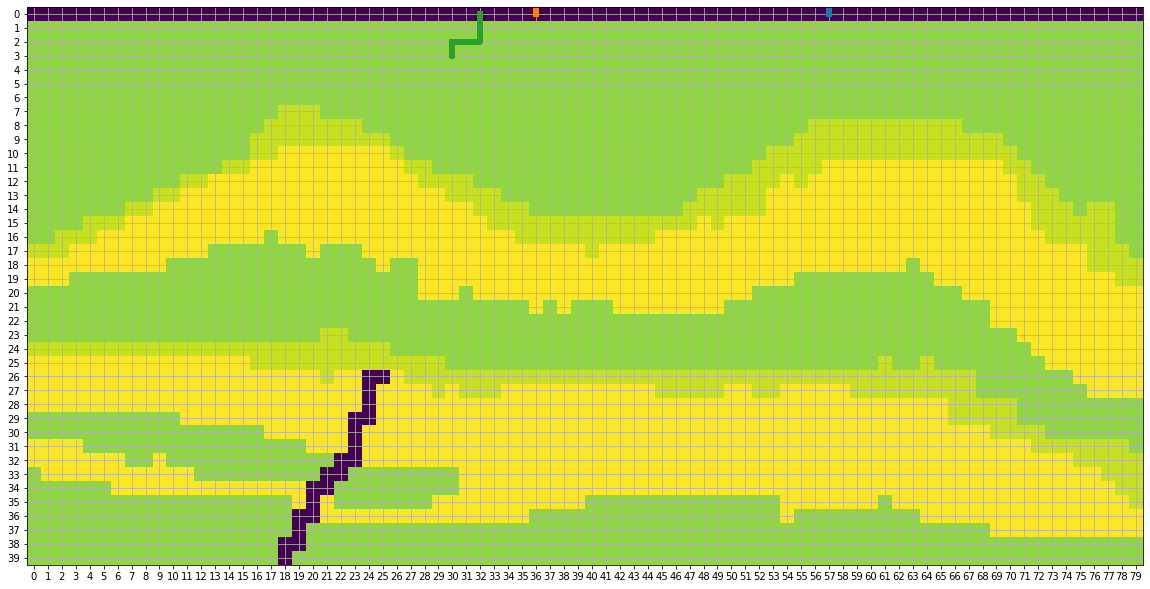

In [588]:
env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=70, num_wells = 3, delim=",")

env = RewardDriller(env_config)

episodes = 1

actions = {
           0: [1, 0],  # down
           1: [0, -1],  # left
           2: [0, 1],  # right
           3: [-1, 0],  # up
          }
    
for episode in range(1,episodes+1):
    
    state = env.reset()
    done = False
    reward = 0
    
    print("Beginning Drill Campaign:", episode)
    
    while not done:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        print(f"    Total Reward: {reward}")

# This comes in as [[row1, col1], ..., [rowN, colN]]
# Once we unpack it its z, then x.
# traj_z, traj_x = np.asarray(env.trajectory).T

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)

for i in range(0,env.num_wells):
    traj_z, traj_x = np.asarray(env.multi_trajectory[i]).T
    plt.plot(traj_x, traj_z, "-", linewidth=6)
    
plt.xticks(np.arange(0, 80, 1.0))
plt.yticks(np.arange(0, 40, 1.0))
plt.xlim([-0.5, 79.5])
plt.ylim([39.5, -0.5])
plt.grid()

# Train the Agent

## PPO

In [ ]:
from stable_baselines3 import PPO

# More the number of wells, more time to train 
env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=70, num_wells = 3, delim=",")
env = RewardDriller(env_config)

ppo = PPO("MlpPolicy", env, verbose=1)
ppo.learn(total_timesteps = 200_000, log_interval=10)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
# env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=70, num_wells = 3, delim=",")
env = RewardDriller(env_config)

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)

episodes = 1
for episode in range(1, episodes + 1):
#     print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
#     reward = 0

    while not done:
        action, _states = model.predict(state)
        state, reward, done, info = env.step(action)
        print(f"    Reward: {reward}")



    for i in range(0,env.num_wells):
        traj_z, traj_x = np.asarray(env.multi_trajectory[i]).T
        plt.plot(traj_x, traj_z, "-", linewidth=6)

    plt.xticks(np.arange(0, 80, 1.0))
    plt.yticks(np.arange(0, 40, 1.0))
    plt.xlim([-0.5, 79.5])
    plt.ylim([39.5, -0.5])
    plt.grid()

## DQN

In [521]:
from stable_baselines3 import DQN

env = RewardDriller(env_config)

dqn = DQN("MlpPolicy", env, verbose=1)
dqn.learn(total_timesteps=100000, log_interval=10)
dqn.save("dqn_pendulum")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | -322     |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 8512     |
|    time_elapsed     | 0        |
|    total_timesteps  | 40       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.05     |
|    ep_rew_mean      | 8        |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 11309    |
|    time_elapsed     | 0        |
|    total_timesteps  | 121      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.97     |
|    ep_rew_mean      | -86.8  

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.65     |
|    ep_rew_mean      | -215     |
|    exploration_rate | 0.881    |
| time/               |          |
|    episodes         | 230      |
|    fps              | 11998    |
|    time_elapsed     | 0        |
|    total_timesteps  | 1252     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.66     |
|    ep_rew_mean      | -251     |
|    exploration_rate | 0.876    |
| time/               |          |
|    episodes         | 240      |
|    fps              | 12007    |
|    time_elapsed     | 0        |
|    total_timesteps  | 1301     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.24     |
|    ep_rew_mean      | -286     |
|    exploration_rate | 0.873    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.63     |
|    ep_rew_mean      | -160     |
|    exploration_rate | 0.774    |
| time/               |          |
|    episodes         | 450      |
|    fps              | 12086    |
|    time_elapsed     | 0        |
|    total_timesteps  | 2381     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.42     |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.77     |
| time/               |          |
|    episodes         | 460      |
|    fps              | 12090    |
|    time_elapsed     | 0        |
|    total_timesteps  | 2418     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.18     |
|    ep_rew_mean      | -222     |
|    exploration_rate | 0.767    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.28     |
|    ep_rew_mean      | -90.3    |
|    exploration_rate | 0.665    |
| time/               |          |
|    episodes         | 670      |
|    fps              | 12592    |
|    time_elapsed     | 0        |
|    total_timesteps  | 3528     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.39     |
|    ep_rew_mean      | -23.5    |
|    exploration_rate | 0.658    |
| time/               |          |
|    episodes         | 680      |
|    fps              | 12624    |
|    time_elapsed     | 0        |
|    total_timesteps  | 3600     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.17     |
|    ep_rew_mean      | -163     |
|    exploration_rate | 0.653    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.89     |
|    ep_rew_mean      | -299     |
|    exploration_rate | 0.553    |
| time/               |          |
|    episodes         | 890      |
|    fps              | 12911    |
|    time_elapsed     | 0        |
|    total_timesteps  | 4702     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.73     |
|    ep_rew_mean      | -315     |
|    exploration_rate | 0.549    |
| time/               |          |
|    episodes         | 900      |
|    fps              | 12925    |
|    time_elapsed     | 0        |
|    total_timesteps  | 4746     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.78     |
|    ep_rew_mean      | -301     |
|    exploration_rate | 0.545    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.2      |
|    ep_rew_mean      | -218     |
|    exploration_rate | 0.448    |
| time/               |          |
|    episodes         | 1110     |
|    fps              | 13174    |
|    time_elapsed     | 0        |
|    total_timesteps  | 5812     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.17     |
|    ep_rew_mean      | -219     |
|    exploration_rate | 0.443    |
| time/               |          |
|    episodes         | 1120     |
|    fps              | 13158    |
|    time_elapsed     | 0        |
|    total_timesteps  | 5858     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.09     |
|    ep_rew_mean      | -286     |
|    exploration_rate | 0.439    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.81     |
|    ep_rew_mean      | -23.8    |
|    exploration_rate | 0.348    |
| time/               |          |
|    episodes         | 1330     |
|    fps              | 13283    |
|    time_elapsed     | 0        |
|    total_timesteps  | 6859     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.92     |
|    ep_rew_mean      | -15.2    |
|    exploration_rate | 0.344    |
| time/               |          |
|    episodes         | 1340     |
|    fps              | 13279    |
|    time_elapsed     | 0        |
|    total_timesteps  | 6910     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.96     |
|    ep_rew_mean      | -22.5    |
|    exploration_rate | 0.338    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.31     |
|    ep_rew_mean      | -229     |
|    exploration_rate | 0.237    |
| time/               |          |
|    episodes         | 1550     |
|    fps              | 13410    |
|    time_elapsed     | 0        |
|    total_timesteps  | 8028     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.26     |
|    ep_rew_mean      | -266     |
|    exploration_rate | 0.232    |
| time/               |          |
|    episodes         | 1560     |
|    fps              | 13428    |
|    time_elapsed     | 0        |
|    total_timesteps  | 8079     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.14     |
|    ep_rew_mean      | -263     |
|    exploration_rate | 0.229    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.04     |
|    ep_rew_mean      | -235     |
|    exploration_rate | 0.129    |
| time/               |          |
|    episodes         | 1770     |
|    fps              | 13483    |
|    time_elapsed     | 0        |
|    total_timesteps  | 9167     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.94     |
|    ep_rew_mean      | -265     |
|    exploration_rate | 0.124    |
| time/               |          |
|    episodes         | 1780     |
|    fps              | 13500    |
|    time_elapsed     | 0        |
|    total_timesteps  | 9219     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.94     |
|    ep_rew_mean      | -247     |
|    exploration_rate | 0.119    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.95     |
|    ep_rew_mean      | -290     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1990     |
|    fps              | 13285    |
|    time_elapsed     | 0        |
|    total_timesteps  | 10291    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.95     |
|    ep_rew_mean      | -331     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2000     |
|    fps              | 13281    |
|    time_elapsed     | 0        |
|    total_timesteps  | 10335    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.12     |
|    ep_rew_mean      | -293     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.97     |
|    ep_rew_mean      | -313     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2210     |
|    fps              | 13219    |
|    time_elapsed     | 0        |
|    total_timesteps  | 11393    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.01     |
|    ep_rew_mean      | -313     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2220     |
|    fps              | 13226    |
|    time_elapsed     | 0        |
|    total_timesteps  | 11439    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -259     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.23     |
|    ep_rew_mean      | -290     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2430     |
|    fps              | 13193    |
|    time_elapsed     | 0        |
|    total_timesteps  | 12550    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.3      |
|    ep_rew_mean      | -284     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2440     |
|    fps              | 13204    |
|    time_elapsed     | 0        |
|    total_timesteps  | 12600    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.31     |
|    ep_rew_mean      | -197     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.21     |
|    ep_rew_mean      | -173     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2650     |
|    fps              | 13261    |
|    time_elapsed     | 1        |
|    total_timesteps  | 13681    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.25     |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2660     |
|    fps              | 13268    |
|    time_elapsed     | 1        |
|    total_timesteps  | 13728    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.34     |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.1      |
|    ep_rew_mean      | -325     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2870     |
|    fps              | 13338    |
|    time_elapsed     | 1        |
|    total_timesteps  | 14828    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.13     |
|    ep_rew_mean      | -325     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2880     |
|    fps              | 13343    |
|    time_elapsed     | 1        |
|    total_timesteps  | 14873    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.99     |
|    ep_rew_mean      | -318     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.43     |
|    ep_rew_mean      | -211     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3090     |
|    fps              | 13437    |
|    time_elapsed     | 1        |
|    total_timesteps  | 15975    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.56     |
|    ep_rew_mean      | -205     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3100     |
|    fps              | 13436    |
|    time_elapsed     | 1        |
|    total_timesteps  | 16040    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.6      |
|    ep_rew_mean      | -205     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.12     |
|    ep_rew_mean      | -349     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3310     |
|    fps              | 13456    |
|    time_elapsed     | 1        |
|    total_timesteps  | 17113    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.2      |
|    ep_rew_mean      | -321     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3320     |
|    fps              | 13456    |
|    time_elapsed     | 1        |
|    total_timesteps  | 17167    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.29     |
|    ep_rew_mean      | -326     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.21     |
|    ep_rew_mean      | -312     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3530     |
|    fps              | 13472    |
|    time_elapsed     | 1        |
|    total_timesteps  | 18273    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.21     |
|    ep_rew_mean      | -310     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3540     |
|    fps              | 13477    |
|    time_elapsed     | 1        |
|    total_timesteps  | 18320    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.32     |
|    ep_rew_mean      | -267     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.1      |
|    ep_rew_mean      | -180     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3750     |
|    fps              | 13474    |
|    time_elapsed     | 1        |
|    total_timesteps  | 19411    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | -181     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3760     |
|    fps              | 13480    |
|    time_elapsed     | 1        |
|    total_timesteps  | 19460    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.05     |
|    ep_rew_mean      | -194     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.23     |
|    ep_rew_mean      | -240     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3970     |
|    fps              | 13453    |
|    time_elapsed     | 1        |
|    total_timesteps  | 20538    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.21     |
|    ep_rew_mean      | -242     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3980     |
|    fps              | 13450    |
|    time_elapsed     | 1        |
|    total_timesteps  | 20574    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.26     |
|    ep_rew_mean      | -247     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.21     |
|    ep_rew_mean      | -255     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4190     |
|    fps              | 13372    |
|    time_elapsed     | 1        |
|    total_timesteps  | 21657    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.14     |
|    ep_rew_mean      | -276     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4200     |
|    fps              | 13372    |
|    time_elapsed     | 1        |
|    total_timesteps  | 21698    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.93     |
|    ep_rew_mean      | -276     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.11     |
|    ep_rew_mean      | -186     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4410     |
|    fps              | 13381    |
|    time_elapsed     | 1        |
|    total_timesteps  | 22814    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.2      |
|    ep_rew_mean      | -189     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4420     |
|    fps              | 13383    |
|    time_elapsed     | 1        |
|    total_timesteps  | 22871    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.23     |
|    ep_rew_mean      | -188     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.87     |
|    ep_rew_mean      | -92      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4630     |
|    fps              | 13419    |
|    time_elapsed     | 1        |
|    total_timesteps  | 24038    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.76     |
|    ep_rew_mean      | -71.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4640     |
|    fps              | 13418    |
|    time_elapsed     | 1        |
|    total_timesteps  | 24090    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.37     |
|    ep_rew_mean      | -196     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.34     |
|    ep_rew_mean      | -125     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4850     |
|    fps              | 13479    |
|    time_elapsed     | 1        |
|    total_timesteps  | 25217    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.22     |
|    ep_rew_mean      | -146     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4860     |
|    fps              | 13481    |
|    time_elapsed     | 1        |
|    total_timesteps  | 25262    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.92     |
|    ep_rew_mean      | -163     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.61     |
|    ep_rew_mean      | -146     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5070     |
|    fps              | 13501    |
|    time_elapsed     | 1        |
|    total_timesteps  | 26374    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.5      |
|    ep_rew_mean      | -146     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5080     |
|    fps              | 13506    |
|    time_elapsed     | 1        |
|    total_timesteps  | 26425    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.38     |
|    ep_rew_mean      | -139     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.37     |
|    ep_rew_mean      | -273     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5290     |
|    fps              | 13534    |
|    time_elapsed     | 2        |
|    total_timesteps  | 27581    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.43     |
|    ep_rew_mean      | -253     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5300     |
|    fps              | 13540    |
|    time_elapsed     | 2        |
|    total_timesteps  | 27647    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.65     |
|    ep_rew_mean      | -220     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.04     |
|    ep_rew_mean      | -169     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5510     |
|    fps              | 13548    |
|    time_elapsed     | 2        |
|    total_timesteps  | 28760    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.82     |
|    ep_rew_mean      | -186     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5520     |
|    fps              | 13548    |
|    time_elapsed     | 2        |
|    total_timesteps  | 28801    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.1      |
|    ep_rew_mean      | -179     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.85     |
|    ep_rew_mean      | 523      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5730     |
|    fps              | 13524    |
|    time_elapsed     | 2        |
|    total_timesteps  | 29970    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.75     |
|    ep_rew_mean      | 511      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5740     |
|    fps              | 13519    |
|    time_elapsed     | 2        |
|    total_timesteps  | 30013    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.99     |
|    ep_rew_mean      | 503      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.83     |
|    ep_rew_mean      | -87.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5950     |
|    fps              | 13447    |
|    time_elapsed     | 2        |
|    total_timesteps  | 31070    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.79     |
|    ep_rew_mean      | -95.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5960     |
|    fps              | 13445    |
|    time_elapsed     | 2        |
|    total_timesteps  | 31118    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.98     |
|    ep_rew_mean      | -92.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.8      |
|    ep_rew_mean      | -59.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6170     |
|    fps              | 13386    |
|    time_elapsed     | 2        |
|    total_timesteps  | 32380    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.77     |
|    ep_rew_mean      | -66.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6180     |
|    fps              | 13390    |
|    time_elapsed     | 2        |
|    total_timesteps  | 32431    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.73     |
|    ep_rew_mean      | -95.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.45     |
|    ep_rew_mean      | 414      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6390     |
|    fps              | 13413    |
|    time_elapsed     | 2        |
|    total_timesteps  | 33654    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.53     |
|    ep_rew_mean      | 435      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6400     |
|    fps              | 13420    |
|    time_elapsed     | 2        |
|    total_timesteps  | 33725    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.46     |
|    ep_rew_mean      | 433      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.11     |
|    ep_rew_mean      | -125     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6610     |
|    fps              | 13432    |
|    time_elapsed     | 2        |
|    total_timesteps  | 34807    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.93     |
|    ep_rew_mean      | -278     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6620     |
|    fps              | 13432    |
|    time_elapsed     | 2        |
|    total_timesteps  | 34846    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.89     |
|    ep_rew_mean      | -280     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.21     |
|    ep_rew_mean      | -161     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6830     |
|    fps              | 13452    |
|    time_elapsed     | 2        |
|    total_timesteps  | 35935    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.51     |
|    ep_rew_mean      | -106     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6840     |
|    fps              | 13456    |
|    time_elapsed     | 2        |
|    total_timesteps  | 36012    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.47     |
|    ep_rew_mean      | -107     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.18     |
|    ep_rew_mean      | -273     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7050     |
|    fps              | 13460    |
|    time_elapsed     | 2        |
|    total_timesteps  | 37063    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.24     |
|    ep_rew_mean      | -276     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7060     |
|    fps              | 13465    |
|    time_elapsed     | 2        |
|    total_timesteps  | 37117    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.5      |
|    ep_rew_mean      | -250     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.58     |
|    ep_rew_mean      | -250     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7270     |
|    fps              | 13471    |
|    time_elapsed     | 2        |
|    total_timesteps  | 38239    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.53     |
|    ep_rew_mean      | -242     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7280     |
|    fps              | 13471    |
|    time_elapsed     | 2        |
|    total_timesteps  | 38281    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.24     |
|    ep_rew_mean      | -304     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.18     |
|    ep_rew_mean      | -252     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7490     |
|    fps              | 13464    |
|    time_elapsed     | 2        |
|    total_timesteps  | 39298    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.06     |
|    ep_rew_mean      | -288     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7500     |
|    fps              | 13464    |
|    time_elapsed     | 2        |
|    total_timesteps  | 39338    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.2      |
|    ep_rew_mean      | -290     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.26     |
|    ep_rew_mean      | -242     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7710     |
|    fps              | 13463    |
|    time_elapsed     | 3        |
|    total_timesteps  | 40449    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.37     |
|    ep_rew_mean      | -253     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7720     |
|    fps              | 13460    |
|    time_elapsed     | 3        |
|    total_timesteps  | 40494    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.18     |
|    ep_rew_mean      | -267     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.98     |
|    ep_rew_mean      | -277     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7930     |
|    fps              | 13418    |
|    time_elapsed     | 3        |
|    total_timesteps  | 41575    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.14     |
|    ep_rew_mean      | -272     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7940     |
|    fps              | 13422    |
|    time_elapsed     | 3        |
|    total_timesteps  | 41627    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.38     |
|    ep_rew_mean      | -191     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.06     |
|    ep_rew_mean      | -179     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8150     |
|    fps              | 13408    |
|    time_elapsed     | 3        |
|    total_timesteps  | 42775    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.89     |
|    ep_rew_mean      | -201     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8160     |
|    fps              | 13409    |
|    time_elapsed     | 3        |
|    total_timesteps  | 42818    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.88     |
|    ep_rew_mean      | -223     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.29     |
|    ep_rew_mean      | -285     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8370     |
|    fps              | 13425    |
|    time_elapsed     | 3        |
|    total_timesteps  | 43972    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.1      |
|    ep_rew_mean      | -273     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8380     |
|    fps              | 13424    |
|    time_elapsed     | 3        |
|    total_timesteps  | 44021    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.17     |
|    ep_rew_mean      | -288     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.59     |
|    ep_rew_mean      | -179     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8590     |
|    fps              | 13436    |
|    time_elapsed     | 3        |
|    total_timesteps  | 45189    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.75     |
|    ep_rew_mean      | -161     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8600     |
|    fps              | 13437    |
|    time_elapsed     | 3        |
|    total_timesteps  | 45244    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.07     |
|    ep_rew_mean      | -71.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.92     |
|    ep_rew_mean      | -326     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8810     |
|    fps              | 13457    |
|    time_elapsed     | 3        |
|    total_timesteps  | 46339    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.38     |
|    ep_rew_mean      | -210     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8820     |
|    fps              | 13458    |
|    time_elapsed     | 3        |
|    total_timesteps  | 46424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.58     |
|    ep_rew_mean      | -190     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.51     |
|    ep_rew_mean      | -347     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9030     |
|    fps              | 13474    |
|    time_elapsed     | 3        |
|    total_timesteps  | 47437    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.66     |
|    ep_rew_mean      | -330     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9040     |
|    fps              | 13475    |
|    time_elapsed     | 3        |
|    total_timesteps  | 47493    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.71     |
|    ep_rew_mean      | -336     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.31     |
|    ep_rew_mean      | -292     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9250     |
|    fps              | 13492    |
|    time_elapsed     | 3        |
|    total_timesteps  | 48591    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.21     |
|    ep_rew_mean      | -294     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9260     |
|    fps              | 13489    |
|    time_elapsed     | 3        |
|    total_timesteps  | 48636    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.94     |
|    ep_rew_mean      | -322     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.36     |
|    ep_rew_mean      | -153     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9470     |
|    fps              | 13483    |
|    time_elapsed     | 3        |
|    total_timesteps  | 49778    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.33     |
|    ep_rew_mean      | -198     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9480     |
|    fps              | 13482    |
|    time_elapsed     | 3        |
|    total_timesteps  | 49831    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.24     |
|    ep_rew_mean      | -234     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.22     |
|    ep_rew_mean      | 310      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9640     |
|    fps              | 12277    |
|    time_elapsed     | 4        |
|    total_timesteps  | 50458    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 85.5     |
|    n_updates        | 114      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.35     |
|    ep_rew_mean      | 3.36e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9650     |
|    fps              | 12153    |
|    time_elapsed     | 4        |
|    total_timesteps  | 50523    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 89.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.3     |
|    ep_rew_mean      | 4.11e+05 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9800     |
|    fps              | 8646     |
|    time_elapsed     | 6        |
|    total_timesteps  | 53114    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38e+03 |
|    n_updates        | 778      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 4.91e+05 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9810     |
|    fps              | 7908     |
|    time_elapsed     | 6        |
|    total_timesteps  | 54059    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 409      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89       |
|    ep_rew_mean      | 1.44e+06 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9960     |
|    fps              | 3928     |
|    time_elapsed     | 17       |
|    total_timesteps  | 67809    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.91e+03 |
|    n_updates        | 4452     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.7     |
|    ep_rew_mean      | 1.46e+06 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9970     |
|    fps              | 3825     |
|    time_elapsed     | 17       |
|    total_timesteps  | 68751    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.93e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 95.6     |
|    ep_rew_mean      | 1.53e+06 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10120    |
|    fps              | 2845     |
|    time_elapsed     | 29       |
|    total_timesteps  | 82736    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.33e+03 |
|    n_updates        | 8183     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.4     |
|    ep_rew_mean      | 1.55e+06 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10130    |
|    fps              | 2808     |
|    time_elapsed     | 29       |
|    total_timesteps  | 83631    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.93e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.3     |
|    ep_rew_mean      | 1.47e+06 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10280    |
|    fps              | 2367     |
|    time_elapsed     | 41       |
|    total_timesteps  | 97738    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.36e+03 |
|    n_updates        | 11934    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.8     |
|    ep_rew_mean      | 1.49e+06 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10290    |
|    fps              | 2322     |
|    time_elapsed     | 42       |
|    total_timesteps  | 98725    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.25e+03 |
|    n_updates      

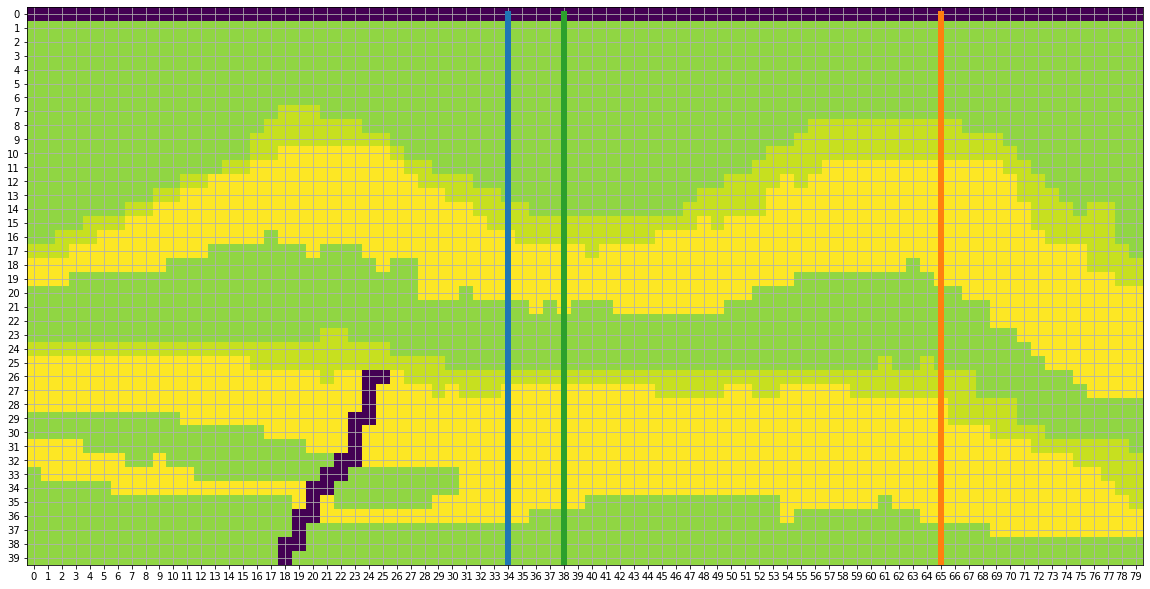

In [528]:
# env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=70, num_wells = 3, delim=",")
env = RewardDriller(env_config)

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)

episodes = 1
for episode in range(1, episodes + 1):
#     print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
#     reward = 0

    while not done:
        action, _states = dqn.predict(state, deterministic=True)
        state, reward, done, info = env.step(action)
#     print(f"    Reward: {reward}")



    for i in range(0,env.num_wells):
        traj_z, traj_x = np.asarray(env.multi_trajectory[i]).T
        plt.plot(traj_x, traj_z, "-", linewidth=6)

    plt.xticks(np.arange(0, 80, 1.0))
    plt.yticks(np.arange(0, 40, 1.0))
    plt.xlim([-0.5, 79.5])
    plt.ylim([39.5, -0.5])
    plt.grid()

## A2C

In [400]:
from stable_baselines3 import A2C

# More the number of wells, more time to train 
# env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=100, num_wells = 3, delim=",")

env = RewardDriller(env_config)

a2c = A2C("MlpPolicy", env, verbose=3)
a2c.learn(total_timesteps=100_000, log_interval=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 43.9      |
|    ep_rew_mean        | 6.85e+05  |
| time/                 |           |
|    fps                | 946       |
|    iterations         | 1000      |
|    time_elapsed       | 5         |
|    total_timesteps    | 5000      |
| train/                |           |
|    entropy_loss       | -0.037    |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 999       |
|    policy_loss        | 7.91      |
|    value_loss         | 2.05e+06  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 89.3      |
|    ep_rew_mean        | 1.6e+06   |
| time/                 |           |
|    fps                | 960       |
|    iterations         | 2000  

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | 2.14e+06  |
| time/                 |           |
|    fps                | 904       |
|    iterations         | 14000     |
|    time_elapsed       | 77        |
|    total_timesteps    | 70000     |
| train/                |           |
|    entropy_loss       | -3.07e-06 |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 13999     |
|    policy_loss        | -0        |
|    value_loss         | 7.83e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | 2.14e+06  |
| time/                 |           |
|    fps                | 900       |
|    iterations         | 15000     |
|    time_elapsed       | 83        |
|    total_timesteps    | 75000     |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 869       |
|    iterations         | 27000     |
|    time_elapsed       | 155       |
|    total_timesteps    | 135000    |
| train/                |           |
|    entropy_loss       | -1.19e-06 |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 26999     |
|    policy_loss        | -0        |
|    value_loss         | 4.1e+10   |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 868       |
|    iterations         | 28000     |
|    time_elapsed       | 161       |
|    total_timesteps    | 140000    |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 118       |
|    ep_rew_mean        | 2.11e+06  |
| time/                 |           |
|    fps                | 850       |
|    iterations         | 40000     |
|    time_elapsed       | 235       |
|    total_timesteps    | 200000    |
| train/                |           |
|    entropy_loss       | -7.76e-07 |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 39999     |
|    policy_loss        | -0        |
|    value_loss         | 9.12e+08  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 846       |
|    iterations         | 41000     |
|    time_elapsed       | 242       |
|    total_timesteps    | 205000    |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 120       |
|    ep_rew_mean        | 2.12e+06  |
| time/                 |           |
|    fps                | 831       |
|    iterations         | 53000     |
|    time_elapsed       | 318       |
|    total_timesteps    | 265000    |
| train/                |           |
|    entropy_loss       | -9.34e-07 |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 52999     |
|    policy_loss        | -0        |
|    value_loss         | 1.85e+04  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 120       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 831       |
|    iterations         | 54000     |
|    time_elapsed       | 324       |
|    total_timesteps    | 270000    |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 829       |
|    iterations         | 66000     |
|    time_elapsed       | 398       |
|    total_timesteps    | 330000    |
| train/                |           |
|    entropy_loss       | -5.54e-07 |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 65999     |
|    policy_loss        | -0        |
|    value_loss         | 1.31e+10  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 829       |
|    iterations         | 67000     |
|    time_elapsed       | 403       |
|    total_timesteps    | 335000    |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 120       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 828       |
|    iterations         | 79000     |
|    time_elapsed       | 476       |
|    total_timesteps    | 395000    |
| train/                |           |
|    entropy_loss       | -1.09e-06 |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 78999     |
|    policy_loss        | -0        |
|    value_loss         | 9.1e+08   |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 120       |
|    ep_rew_mean        | 2.13e+06  |
| time/                 |           |
|    fps                | 828       |
|    iterations         | 80000     |
|    time_elapsed       | 482       |
|    total_timesteps    | 400000    |
| train/    

KeyboardInterrupt: 

In [ ]:
env = RewardDriller(env_config)

episodes = 10

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)

for episode in range(1, episodes + 1):
    print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
#     reward = 0

    while not done:
        action, _states = a2c.predict(state)
        state, reward, done, info = env.step(action)
    print(f"    Reward: {reward}")

    for i in range(0,env.num_wells):
        traj_z, traj_x = np.asarray(env.multi_trajectory[i]).T
        plt.plot(traj_x, traj_z, "-", linewidth=6)

    plt.xticks(np.arange(0, 80, 1.0))
    plt.yticks(np.arange(0, 40, 1.0))
    plt.xlim([-0.5, 79.5])
    plt.ylim([39.5, -0.5])
    plt.grid()